In [1]:
import pandas as pd
from data_loader import load 
data = load("collections_email.csv")
data.head()

/var/folders/_v/zpy46p6s4g3g177nfz68d4hh0000gn/T/ipykernel_23252/1938535927.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,payments,email,opened,agreement,credit_limit,risk_score
0,740,1,1.0,0.0,2348.495260,0.666752
1,580,1,1.0,1.0,334.111969,0.207395
2,600,1,1.0,1.0,1360.660722,0.550479
3,770,0,0.0,0.0,1531.828576,0.560488
4,660,0,0.0,0.0,979.855647,0.455140


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('dark_background')
import seaborn as sns
import pandas as pd 
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
print("Difference in means:",
      data.query("email==1")["payments"].mean() - data.query("email==0")["payments"].mean())

model = smf.ols('payments ~ email', data=data).fit()
model.summary().tables[1]

Difference in means: -0.6202804021329484


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,669.9764,2.061,325.116,0.000,665.937,674.016
email,-0.6203,2.941,-0.211,0.833,-6.387,5.146


- a control doesn't have to eliminate a cofoound. can just explain variance
- Adding extra variables to a regression means keeping them constant while looking at the treatment.

## Partialling out 

In [4]:
# Regress treatment (email) and outcome (payments) on the controls: credit, risk
model_email = smf.ols('email ~ credit_limit + risk_score', data=data).fit()
model_payments = smf.ols('payments ~ credit_limit + risk_score', data=data).fit()
# Regress residuals of treatment on residuals of payments
residuals = pd.DataFrame(dict(res_payments=model_payments.resid, res_email=model_email.resid))
residuals


,res_payments,res_email
0,-102.119305,0.585020
1,38.349917,0.552893
2,-94.253934,0.488132
3,50.076379,-0.487533
4,22.507264,-0.511614
...,...,...
4995,76.781576,-0.473346
4996,74.484265,-0.506540
4997,44.443826,0.519422
4998,40.636872,0.501449


In [5]:
model_treatment = smf.ols('res_payments ~ res_email', data=residuals).fit()
model_treatment

Regressing payments on credit = payments ~ credit

In [6]:
print("Payments Variance", np.var(data["payments"]))
print("Payments Residual Variance", np.var(residuals["res_payments"]))

print("Email Variance", np.var(data["email"]))
print("Email Residual Variance", np.var(residuals["res_email"]))

Payments Variance 10807.612416
Payments Residual Variance 5652.453558466206
Email Variance 0.24991536
Email Residual Variance 0.24918421069820032


Emails is unpredictable so regressing on it can't drop it's variance

In [7]:

model_treatment.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.102e-13,1.063,1.04e-13,1.000,-2.084,2.084
res_email,4.4304,2.129,2.080,0.038,0.256,8.605


Customers pay 4.4 more than control 

In [8]:
model_2 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


Same results putting everyting in the same model 

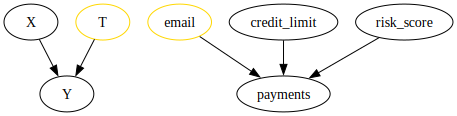

In [9]:
import graphviz as gr

g = gr.Digraph()
g.edge("X", "Y"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("email", color="gold")
g.edge("credit_limit", "payments")
g.edge("risk_score", "payments")
g.edge("email", "payments")

g

# Harmful controls 

- Hospital A gets more severity, applies 90% true drug, 10% placebo
- Hospital B gets less severity, applies 10% true drug, 90% placebo

In [12]:
hospital = load("hospital_treatment.csv")
hospital.head()


,hospital,treatment,severity,days
0,1,1,29.686618,82
1,1,1,20.050340,57
2,1,1,20.302399,49
3,0,0,10.603118,44
4,0,0,8.332793,15


Because RCT can start with regression to get effect

In [13]:
hosp_1 = smf.ols('days ~ treatment', data=hospital).fit()
hosp_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,33.2667,2.662,12.498,0.000,27.968,38.566
treatment,14.1533,3.367,4.204,0.000,7.451,20.856


But severity is a **cofounder** as it effects treatment (more sevre more likely to get treated as more likely to be at hospital A) and days in hospital

One solution is to look at each hospital seperately

In [14]:
hosp_2 = smf.ols('days ~ treatment', data=hospital.query("hospital==0")).fit()
hosp_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.4074,2.868,10.602,0.000,24.523,36.292
treatment,-11.4074,10.921,-1.045,0.306,-33.816,11.001


In [15]:
hosp_3 = smf.ols('days ~ treatment', data=hospital.query("hospital==1")).fit()
hosp_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,59.0000,6.747,8.745,0.000,45.442,72.558
treatment,-10.3958,6.955,-1.495,0.141,-24.371,3.580


This gives us some insight into effect, but not the true effeect. Because we don't have much data the results are not significant


Better is including it in the model

In [16]:
hosp_4 = smf.ols('days ~ treatment + severity', data=hospital).fit()
hosp_4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.6641,2.000,5.832,0.000,7.681,15.647
treatment,-7.5912,2.269,-3.345,0.001,-12.110,-3.073
severity,2.2741,0.154,14.793,0.000,1.968,2.580


What happens if we add the hospital as a predictor just for fun



In [17]:
hosp_5 = smf.ols('days ~ treatment + severity + hospital', data=hospital).fit()
hosp_5.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.0111,2.118,5.198,0.000,6.792,15.230
treatment,-5.0945,3.492,-1.459,0.149,-12.049,1.861
severity,2.3865,0.195,12.251,0.000,1.999,2.774
hospital,-4.1535,4.413,-0.941,0.350,-12.943,4.636


Now the ATE is not statistically significant!

In [18]:
model_treatment = smf.ols('treatment ~ severity + hospital', data=hospital).fit()
model_days = smf.ols('days ~ severity + hospital', data=hospital).fit()

residuals = pd.DataFrame(dict(res_days=model_days.resid, res_treatment=model_treatment.resid))

model_treatment = smf.ols('res_days ~ res_treatment', data=residuals).fit()

model_treatment.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.061e-14,0.827,2.49e-14,1.000,-1.646,1.646
res_treatment,-5.0945,3.447,-1.478,0.143,-11.957,1.768


^ partitioning out. same as 3-way model for ATE

- So the bottom line is that we should add controls that are both correlated with the treatment and the outcome... (this is confounder)
- We should also add controls that are good predictors of the outcome, even if they are not confounders, because they lower the variance of our estimates.
- However, we should NOT add controls that are just good predictors of the treatment, because they will increase the variance of our estimates.

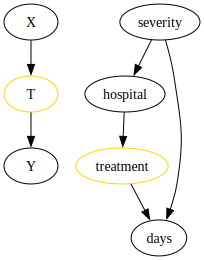

In [19]:
g = gr.Digraph()

g.edge("X", "T"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("treatment", color="gold")
g.edge("severity", "hospital")
g.edge("severity", "days")
g.edge("hospital", "treatment")
g.edge("treatment", "days")

g

# Selection bias 

In [21]:
import pandas as pd
data = load("collections_email.csv")
data.head()

,payments,email,opened,agreement,credit_limit,risk_score
0,740,1,1.0,0.0,2348.495260,0.666752
1,580,1,1.0,1.0,334.111969,0.207395
2,600,1,1.0,1.0,1360.660722,0.550479
3,770,0,0.0,0.0,1531.828576,0.560488
4,660,0,0.0,0.0,979.855647,0.455140


- opened is a dummy variable for the customer opening the email or not.
- agreement is another dummy marking if the customers contacted the collections department to negotiate their debt, after having received the email.

Are these good variables to add? 
- Assuming opened = not read at all? No because we modelling effect of sending email not of an email being opened
- agreement. 

In [22]:
email_1 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
email_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


In [23]:
email_2 = smf.ols('payments ~ email + credit_limit + risk_score + opened + agreement', data=data).fit()
email_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,488.4416,9.716,50.272,0.000,469.394,507.489
email,-1.6095,2.724,-0.591,0.555,-6.949,3.730
credit_limit,0.1507,0.008,18.809,0.000,0.135,0.166
risk_score,-2.0929,38.375,-0.055,0.957,-77.325,73.139
opened,3.9808,3.914,1.017,0.309,-3.692,11.654
agreement,11.7093,4.166,2.811,0.005,3.542,19.876


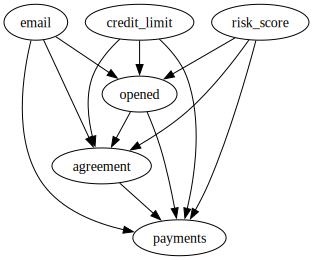

In [24]:
g = gr.Digraph()

g.edge("email", "payments")
g.edge("email", "opened")
g.edge("email", "agreement")
g.edge("opened", "payments")
g.edge("opened", "agreement")
g.edge("agreement", "payments")

g.edge("credit_limit", "payments")
g.edge("credit_limit", "opened")
g.edge("credit_limit", "agreement")
g.edge("risk_score", "payments")
g.edge("risk_score", "opened")
g.edge("risk_score", "agreement")

g

Opened and agreement are part of the causal effect oemail. Fixing them will remove some of the ATE

Some reasoning:
We can guess:
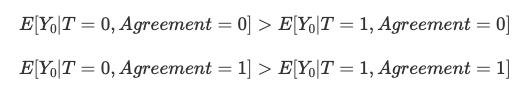

For eq1:
- WIthout email and without agreement are better than those with email and without agreement
  - This is KEY. If we think there's a positive effect then these guys must be worse with same positive effect

FOr eq2: 
- Those without positive email effect and agreement are better than those with positive email effect that made agreement
 

- confounding is the bias from failing to control for a common cause
- selection bias is controlling for a common effect OR VARIABLE IN PATH FROM CAUSE TO EFFECT
- - RCT DOESNT FIX

As a rule:
- include: cofounders and good predictors of Y
- exlucde: good predictors of ONLY T and mediators 

# The bad cop

Common case of selection bias 

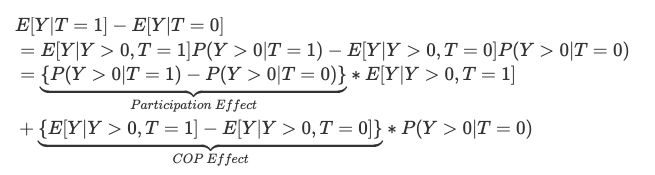

Conditional-on-Positives effect: learn effect of positive case. overestimates as doesn't consider the quality of positive case detection
- participation effect = how much more likely tp be Y>0 if treated
- COP effect = effect of treatment on non zero Y units

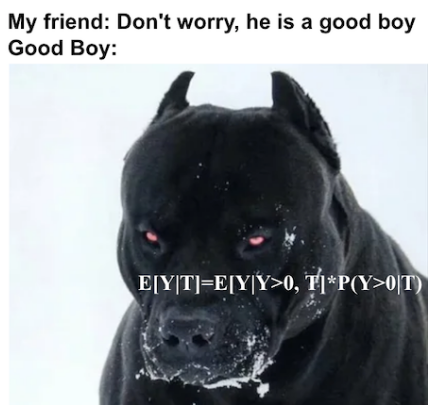

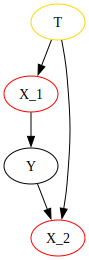

In [25]:
g = gr.Digraph()

g.edge("T", "X_1"), g.node("T", color="gold"), g.edge("X_1", "Y"), g.node("X_1", color="red")
g.edge("T", "X_2"), g.edge("Y", "X_2"), g.node("X_2", color="red")

g

We never:
- control for variable that is between treatment and outcome
- common effect of treatment and outcome 